# **COVID-19 Diagnosis using X-Ray Images and Deep learning**

## **Importing Modules**

In [1]:
! pip install efficientnet_pytorch

Processing /home/celery/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc/efficientnet_pytorch-0.7.1-py3-none-any.whl
     |████████████████████████████████| 890.2 MB 9.6 kB/s  eta 0:00:01
     |████████████████████████████████| 21.0 MB 79.9 MB/s eta 0:00:01
     |████████████████████████████████| 317.1 MB 47 kB/s s eta 0:00:01
     |████████████████████████████████| 557.1 MB 15 kB/s s eta 0:00:01
     |████████████████████████████████| 849 kB 53.6 MB/s eta 0:00:01
You should consider upgrading via the '/home/celery/.pyenv/versions/3.8.8/bin/python3.8 -m pip install --upgrade pip' command.


In [5]:
#importing required modules

import gdown
import zipfile
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import datasets, transforms as T
from torchvision import models, transforms
from efficientnet_pytorch import EfficientNet

import os
import torch.optim as optim
from PIL import ImageFile

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## **Data Preprocessing**

In [6]:
#importing data

#Dataset address
url = 'https://drive.google.com/uc?export=download&id=1B75cOYH7VCaiqdeQYvMuUuy_Mn_5tPMY'
output = 'data.zip'
gdown.download(url, output, quiet=False)

#giving zip file name
data_dir='./data.zip'

#extractng data from zip file
with zipfile.ZipFile(data_dir, 'r') as zf:
    zf.extractall('./data/')

#removing zip file after extraction
#!rm './data.zip' 

#checking the availability of a GPU
use_cuda = torch.cuda.is_available()

Downloading...
From: https://drive.google.com/uc?export=download&id=1B75cOYH7VCaiqdeQYvMuUuy_Mn_5tPMY
To: /home/celery/Workspace/Git/COVID-19-Classification/data.zip
100%|██████████| 46.1M/46.1M [00:03<00:00, 11.7MB/s]


In [7]:
#declaring batch size
batch_size = 32

#applying required transformations on the dataset
img_transforms = {
    'train':
    T.Compose([
        T.Resize(size=(224,224)), 
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]), 
        ]),

    'valid':
    T.Compose([
        T.Resize(size=(224,224)),
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),

    'test':
    T.Compose([
        T.Resize(size=(224,224)),
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
     }

# creating Location of data: train, validation, test
data='./data/'

train_path=os.path.join(data,'train')
valid_path=os.path.join(data,'test')
test_path=os.path.join(data,'valid')


# creating Datasets to each of  folder created in prev
train_file=datasets.ImageFolder(train_path,transform=img_transforms['train'])
valid_file=datasets.ImageFolder(valid_path,transform=img_transforms['valid'])
test_file=datasets.ImageFolder(test_path,transform=img_transforms['test'])


#Creating loaders for the dataset
loaders_transfer={
    'train':torch.utils.data.DataLoader(train_file,batch_size,shuffle=True),
    'valid':torch.utils.data.DataLoader(valid_file,batch_size,shuffle=True),
    'test': torch.utils.data.DataLoader(test_file,batch_size,shuffle=True)
}

In [8]:
print(train_file)
print(valid_file)
print(test_file)

Dataset ImageFolder
    Number of datapoints: 3702
    Root location: ./data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
Dataset ImageFolder
    Number of datapoints: 462
    Root location: ./data/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
Dataset ImageFolder
    Number of datapoints: 462
    Root location: ./data/valid
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )


## **Model Building**

In [9]:
#importing the pretrained EfficientNet model

model_transfer = EfficientNet.from_pretrained('efficientnet-b3')
#model_transfer = models.resnet50(pretrained=True)
# Freeze weights
for param in model_transfer.parameters():
    param.requires_grad = False
in_features = model_transfer._fc.in_features
#in_features = model_transfer.fc.in_features

# Defining Dense top layers after the convolutional layers
model_transfer._fc = nn.Sequential(
    nn.BatchNorm1d(num_features=in_features),    
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=128),
    nn.Dropout(0.4),
    nn.Linear(128, 2),
    )
if use_cuda:
    model_transfer = model_transfer.cuda()

Loaded pretrained weights for efficientnet-b3


In [10]:
# Plotting the summary of the model

summary(model_transfer, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 40, 112, 112]           1,080
       BatchNorm2d-3         [-1, 40, 112, 112]              80
MemoryEfficientSwish-4         [-1, 40, 112, 112]               0
         ZeroPad2d-5         [-1, 40, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 40, 112, 112]             360
       BatchNorm2d-7         [-1, 40, 112, 112]              80
MemoryEfficientSwish-8         [-1, 40, 112, 112]               0
          Identity-9             [-1, 40, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 10, 1, 1]             410
MemoryEfficientSwish-11             [-1, 10, 1, 1]               0
         Identity-12             [-1, 10, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 40, 1, 1]             440
         I

In [11]:
# selecting loss function
criterion_transfer = nn.CrossEntropyLoss()

#using Adam classifier
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.0005)

## **Training and Validating the Model**

In [12]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Creating the function for training
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    trainingloss = []
    validationloss = []

    for epoch in range(1, n_epochs+1):
        # initialize the variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # training the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
          
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
           
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
    
        ######################    
        # validating the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
        
        train_loss = train_loss/len(train_file)
        valid_loss = valid_loss/len(valid_file)

        trainingloss.append(train_loss)
        validationloss.append(valid_loss)

        # printing training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## saving the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            
            valid_loss_min = valid_loss
            
    # return trained model
    return model, trainingloss, validationloss

In [13]:
# training the model

n_epochs=10

model_transfer, train_loss, valid_loss = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model.pt')

Epoch: 1 	Training Loss: 0.000071 	Validation Loss: 0.000524
Epoch: 2 	Training Loss: 0.000048 	Validation Loss: 0.000822
Epoch: 3 	Training Loss: 0.000044 	Validation Loss: 0.000940
Epoch: 4 	Training Loss: 0.000038 	Validation Loss: 0.000936
Epoch: 5 	Training Loss: 0.000034 	Validation Loss: 0.000858
Epoch: 6 	Training Loss: 0.000036 	Validation Loss: 0.000534
Epoch: 7 	Training Loss: 0.000032 	Validation Loss: 0.002597
Epoch: 8 	Training Loss: 0.000027 	Validation Loss: 0.000217
Epoch: 9 	Training Loss: 0.000029 	Validation Loss: 0.000182
Epoch: 10 	Training Loss: 0.000030 	Validation Loss: 0.000203


In [14]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

##  **Testing the Model**

In [15]:
# Defining the test function

def test(loaders, model, criterion, use_cuda):

    # monitoring test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    preds = []
    targets = []

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['valid']):
        # moving to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # updating average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # converting the output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        preds.append(pred)
        targets.append(target)
        # compare predictions
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
    
    return preds, targets

# calling test function
preds, targets = test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

## **Visulizing the results**

In [16]:
#converting the tensor object to a list for metric functions

preds2, targets2 = [],[]

for i in preds:
  for j in range(len(i)):
    preds2.append(i.cpu().numpy()[j])
for i in targets:
  for j in range(len(i)):
    targets2.append(i.cpu().numpy()[j])

In [17]:
#Computing the accuracy
acc = accuracy_score(targets2, preds2)
print("Accuracy: ", acc)

Accuracy:  0.9718614718614719


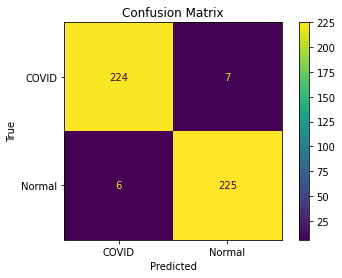

In [18]:
cm = confusion_matrix(targets2, preds2)

#Create an object for the confusion matrix display class
cmob = ConfusionMatrixDisplay(cm, display_labels=['COVID', 'Normal'])


# The plot() function has to be called for the sklearn visualization
cmob.plot()

# Use the Axes attribute 'ax_' to get to the underlying Axes object.
cmob.ax_.set(title='Confusion Matrix', 
            xlabel='Predicted', 
            ylabel='True')

# Finally, call the matplotlib show() function to display the visualization
plt.show()

In [33]:
def func(val):
    return val.detach().cpu().numpy()
train_loss_list = list(map(func, train_loss))
val_loss_list = list(map(func, valid_loss))

Text(0, 0.5, 'loss')

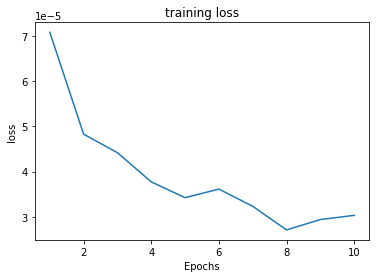

In [32]:
#Plotting the training loss

plt.plot(range(1,1+n_epochs),train_loss_list)
plt.title("training loss")
plt.xlabel('Epochs')
plt.ylabel("loss")

Text(0, 0.5, 'loss')

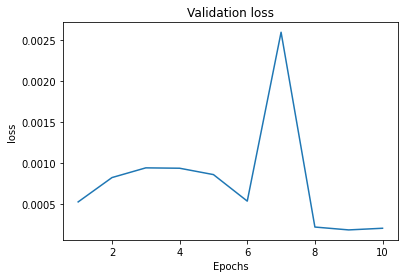

In [35]:
#Plotting the validation loss

plt.plot(range(1,1+n_epochs),val_loss_list)
plt.title("Validation loss")
plt.xlabel('Epochs')
plt.ylabel("loss")